### Need to change cells:
* Calculate factors
* Calculating Factor's Values
* Plotting Prices and Factor's values

In [1]:
import pandas as pd
import os
import time
import patoolib
import gzip
import shutil
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from mpl_finance import candlestick_ohlc
import openpyxl
import datetime as dt

In [2]:
inst = "EURGBP"
str1 = (r"L:\Raw_1_sec_Bar_Data\FX\{}\Pickle\{}_all_files.pkl.gz".format(inst,inst))
str2 = (r"L:\Raw_1_sec_Bar_Data\FX\{}\Pickle\\".format(inst))
patoolib.extract_archive(str1, outdir=str2)

patool: Extracting L:\Raw_1_sec_Bar_Data\FX\EURGBP\Pickle\EURGBP_all_files.pkl.gz ...
patool: running "C:\Program Files\7-Zip\7z.EXE" e -oL:\Raw_1_sec_Bar_Data\FX\EURGBP\Pickle\\ -- L:\Raw_1_sec_Bar_Data\FX\EURGBP\Pickle\EURGBP_all_files.pkl.gz
patool: ... L:\Raw_1_sec_Bar_Data\FX\EURGBP\Pickle\EURGBP_all_files.pkl.gz extracted to `L:\Raw_1_sec_Bar_Data\FX\EURGBP\Pickle\\'.


'L:\\Raw_1_sec_Bar_Data\\FX\\EURGBP\\Pickle\\\\'

In [3]:
df = pd.read_pickle(r"L:\Raw_1_sec_Bar_Data\FX\{}\Pickle\{}.pkl".format(inst,inst))
analyzed_df = df["2020-03"]

In [4]:
analyzed_df.head()

,Open,High,Low,Close
DateTime_UTC,,,,
2020-03-02 00:00:00,0.863100,0.863175,0.863100,0.863175
2020-03-02 00:00:01,0.863175,0.863200,0.863150,0.863175
2020-03-02 00:00:02,0.863175,0.863200,0.863150,0.863150
2020-03-02 00:00:03,0.863150,0.863150,0.863125,0.863125
2020-03-02 00:00:04,0.863125,0.863150,0.863100,0.863150


In [5]:
df.head()

,Open,High,Low,Close
DateTime_UTC,,,,
2018-02-19 00:00:00,0.884600,0.884625,0.884600,0.884625
2018-02-19 00:00:01,0.884625,0.884650,0.884625,0.884650
2018-02-19 00:00:02,0.884650,0.884650,0.884650,0.884650
2018-02-19 00:00:03,0.884650,0.884650,0.884650,0.884650
2018-02-19 00:00:04,0.884650,0.884650,0.884650,0.884650


In [6]:
df.tail()

,Open,High,Low,Close
DateTime_UTC,,,,
2020-04-03 20:59:55,0.880950,0.880950,0.880950,0.880950
2020-04-03 20:59:56,0.880950,0.880950,0.880875,0.880925
2020-04-03 20:59:57,0.880925,0.880925,0.880925,0.880925
2020-04-03 20:59:58,0.880925,0.880925,0.880925,0.880925
2020-04-03 20:59:59,0.880925,0.880925,0.880925,0.880925


### Inspecting one day

In [39]:
analyzed_df["2019-06-12 09:06:58":"2019-06-12 09:07:02"]

,Open,High,Low,Close
DateTime_UTC,,,,
2019-06-12 09:06:58,1.273900,1.2739,1.273900,1.273900
2019-06-12 09:06:59,1.273900,1.2739,1.273900,1.273900
2019-06-12 09:07:00,1.273900,1.2739,1.273875,1.273875
2019-06-12 09:07:01,1.273875,1.2739,1.273875,1.273900
2019-06-12 09:07:02,1.273900,1.2739,1.273875,1.273875


## Selecting Date and Size

In [7]:
class Trade_Size:
    size = 20000

trading_date = "2018-03"

start_date = "2018-02-19"
end_date = "2020-04-03"

filter_days = []
filter_hours = range(8,20) # UTC timezone
filter_mins = []
filter_secs = []

# For resampling
resample_interval = "15T"

# For calculating factors
num_of_std_dev = 3
lookback = 20 # Days
index_frequency = pd.Timedelta(minutes=15)


#analyzed_df = df[trading_date]
analyzed_df = df.loc[start_date:end_date,:]
analyzed_df.head()

,Open,High,Low,Close
DateTime_UTC,,,,
2018-02-19 00:00:00,0.884600,0.884625,0.884600,0.884625
2018-02-19 00:00:01,0.884625,0.884650,0.884625,0.884650
2018-02-19 00:00:02,0.884650,0.884650,0.884650,0.884650
2018-02-19 00:00:03,0.884650,0.884650,0.884650,0.884650
2018-02-19 00:00:04,0.884650,0.884650,0.884650,0.884650


### Resampling into 1 Minute bars

In [8]:
min_1_low = analyzed_df.loc[:,"Low"].resample(resample_interval).apply(np.min)
min_1_high = analyzed_df.loc[:,"High"].resample(resample_interval).apply(np.max)
min_1_open = analyzed_df.loc[:,"Open"].resample(resample_interval).first()
min_1_close = analyzed_df.loc[:,"Close"].resample(resample_interval).last()
#min_1_Trading_date_Actual_Time = analyzed_df.loc[:,"Trading_date_Actual_Time"].resample(resample_interval).first()
#min_1_Trading_date_Sequential_Time = analyzed_df.loc[:,"Trading_date_Sequential_Time"].resample(resample_interval).first()

# min_1_analyzed_df = pd.DataFrame.from_dict({"Open":min_1_open,"High":min_1_high,"Low":min_1_low,"Close":min_1_close,
#                                         "Trading_date_Actual_Time":min_1_Trading_date_Actual_Time,
#                                         "Trading_date_Sequential_Time":min_1_Trading_date_Sequential_Time})

min_1_analyzed_df = pd.DataFrame.from_dict({"Open":min_1_open,"High":min_1_high,"Low":min_1_low,"Close":min_1_close})

min_1_analyzed_df.head()

,Open,High,Low,Close
DateTime_UTC,,,,
2018-02-19 00:00:00,0.884600,0.885075,0.884600,0.884975
2018-02-19 00:15:00,0.884975,0.885000,0.884725,0.884750
2018-02-19 00:30:00,0.884750,0.884925,0.884650,0.884725
2018-02-19 00:45:00,0.884725,0.884825,0.884650,0.884750
2018-02-19 01:00:00,0.884750,0.884925,0.884700,0.884850


### Calculate factors

In [9]:
min_1_analyzed_df_temp = min_1_analyzed_df
min_1_analyzed_df_temp["DateTime_UTC_column"] = min_1_analyzed_df_temp.index

min_1_analyzed_df["Middle_Band"] = min_1_analyzed_df["Close"].rolling(lookback).mean()
min_1_analyzed_df["Upper_Band"] = min_1_analyzed_df["Middle_Band"] + \
(min_1_analyzed_df["Close"].rolling(lookback).std()*num_of_std_dev)
min_1_analyzed_df["Lower_Band"] = min_1_analyzed_df["Middle_Band"] - \
(min_1_analyzed_df["Close"].rolling(lookback).std()*num_of_std_dev)
min_1_analyzed_df["Prev_Lower_Band"] = min_1_analyzed_df["Lower_Band"].shift(1)
min_1_analyzed_df["Prev_Upper_Band"] = min_1_analyzed_df["Upper_Band"].shift(1)
min_1_analyzed_df["Upper_Lower_Band_Span"] = min_1_analyzed_df["Upper_Band"] - min_1_analyzed_df["Lower_Band"]
min_1_analyzed_df["Candle_High_and_Close_above_U_Band"] = min_1_analyzed_df["Close"] > min_1_analyzed_df["Upper_Band"]
min_1_analyzed_df["Prev_Candle_High_and_Close_above_U_Band"] = min_1_analyzed_df["Candle_High_and_Close_above_U_Band"].shift(1)
min_1_analyzed_df.drop("Candle_High_and_Close_above_U_Band",axis=1,inplace=True)
min_1_analyzed_df["Candle_Low_and_Close_below_L_Band"] = min_1_analyzed_df["Close"] < min_1_analyzed_df["Lower_Band"]
min_1_analyzed_df["Prev_Candle_Low_and_Close_below_L_Band"] = min_1_analyzed_df["Candle_Low_and_Close_below_L_Band"].shift(1)
min_1_analyzed_df.drop("Candle_Low_and_Close_below_L_Band",axis=1,inplace=True)
#min_1_analyzed_df["Is_Prev_Cndl_Up"] = ((min_1_analyzed_df["Close"].shift(1) - min_1_analyzed_df["Open"].shift(1)) >= 0)
#min_1_analyzed_df["Is_Prev_Cndl_Down"] = ((min_1_analyzed_df["Close"].shift(1) - min_1_analyzed_df["Open"].shift(1)) < 0)
min_1_analyzed_df["Five_per_std"] = min_1_analyzed_df["Close"].rolling(5).std()
min_1_analyzed_df["Prev_High"] = min_1_analyzed_df["High"].shift(1)
min_1_analyzed_df["Prev_Low"] = min_1_analyzed_df["Low"].shift(1)

def Dict_of_Closing_Prices_Creation(row):
    if row.DateTime_UTC_column > min_1_analyzed_df.iloc[lookback-1,:].name:
        Dict_of_Closing_Prices = {}
        for n in range(1, lookback):
            new_DateTime_UTC = row.DateTime_UTC_column-(index_frequency*(n))
            Dict_of_Closing_Prices[new_DateTime_UTC] = min_1_analyzed_df.loc[new_DateTime_UTC,"Close"]
        return Dict_of_Closing_Prices
    else:
        return np.nan

min_1_analyzed_df["Dict_of_Closing_Prices"] = min_1_analyzed_df_temp.apply(Dict_of_Closing_Prices_Creation, axis=1)    

# min_1_analyzed_df["Prev_5_Per_Seventy_SMA"] = min_1_analyzed_df["Seventy_SMA"].shift(5)
# min_1_analyzed_df["SMA10_vs_SMA20"] = min_1_analyzed_df["SMA10"] - min_1_analyzed_df["SMA20"]
# min_1_analyzed_df["SMA10_vs_SMA20_Shifted"] = min_1_analyzed_df["SMA10_vs_SMA20"].shift(1)
min_1_analyzed_df.head(25)

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,Upper_Lower_Band_Span,Prev_Candle_High_and_Close_above_U_Band,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices
DateTime_UTC,,,,,,,,,,,,,,,,,
2018-02-19 00:00:00,0.884600,0.885075,0.884600,0.884975,2018-02-19 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-02-19 00:15:00,0.884975,0.885000,0.884725,0.884750,2018-02-19 00:15:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,0.885075,0.884600,NaN
2018-02-19 00:30:00,0.884750,0.884925,0.884650,0.884725,2018-02-19 00:30:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,0.885000,0.884725,NaN
2018-02-19 00:45:00,0.884725,0.884825,0.884650,0.884750,2018-02-19 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,NaN,0.884925,0.884650,NaN
2018-02-19 01:00:00,0.884750,0.884925,0.884700,0.884850,2018-02-19 01:00:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.000104,0.884825,0.884650,NaN
2018-02-19 01:15:00,0.884850,0.884950,0.884750,0.884900,2018-02-19 01:15:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.000076,0.884925,0.884700,NaN
2018-02-19 01:30:00,0.884900,0.885050,0.884800,0.884950,2018-02-19 01:30:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.000096,0.884950,0.884750,NaN
2018-02-19 01:45:00,0.884950,0.885150,0.884900,0.885050,2018-02-19 01:45:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.000112,0.885050,0.884800,NaN
2018-02-19 02:00:00,0.885050,0.885050,0.884825,0.884950,2018-02-19 02:00:00,NaN,NaN,NaN,NaN,NaN,NaN,False,False,0.000074,0.885150,0.884900,NaN


### Dropping N.As

In [10]:
min_1_analyzed_df.dropna(inplace=True)
min_1_analyzed_df.head(35)

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,Upper_Lower_Band_Span,Prev_Candle_High_and_Close_above_U_Band,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices
DateTime_UTC,,,,,,,,,,,,,,,,,
2018-02-19 05:00:00,0.884825,0.884875,0.884675,0.884725,2018-02-19 05:00:00,0.884796,0.885128,0.884464,0.884460,0.885157,0.000664,False,False,0.000065,0.884925,0.884700,"{2018-02-19 04:45:00: 0.884825, 2018-02-19 04:..."
2018-02-19 05:15:00,0.884725,0.884875,0.884625,0.884775,2018-02-19 05:15:00,0.884798,0.885128,0.884467,0.884464,0.885128,0.000662,False,False,0.000048,0.884875,0.884675,"{2018-02-19 05:00:00: 0.884725, 2018-02-19 04:..."
2018-02-19 05:30:00,0.884775,0.885300,0.884750,0.885250,2018-02-19 05:30:00,0.884824,0.885268,0.884379,0.884467,0.885128,0.000889,False,False,0.000218,0.884875,0.884625,"{2018-02-19 05:15:00: 0.884775, 2018-02-19 05:..."
2018-02-19 05:45:00,0.885250,0.885375,0.885125,0.885350,2018-02-19 05:45:00,0.884854,0.885417,0.884290,0.884379,0.885268,0.001127,False,False,0.000292,0.885300,0.884750,"{2018-02-19 05:30:00: 0.88525, 2018-02-19 05:1..."
2018-02-19 06:00:00,0.885350,0.885400,0.885200,0.885225,2018-02-19 06:00:00,0.884872,0.885489,0.884256,0.884290,0.885417,0.001232,False,False,0.000292,0.885375,0.885125,"{2018-02-19 05:45:00: 0.88535, 2018-02-19 05:3..."
2018-02-19 06:15:00,0.885225,0.885350,0.885125,0.885200,2018-02-19 06:15:00,0.884887,0.885542,0.884233,0.884256,0.885489,0.001308,False,False,0.000223,0.885400,0.885200,"{2018-02-19 06:00:00: 0.885225, 2018-02-19 05:..."
2018-02-19 06:30:00,0.885200,0.885275,0.885000,0.885025,2018-02-19 06:30:00,0.884891,0.885551,0.884232,0.884233,0.885542,0.001319,False,False,0.000118,0.885350,0.885125,"{2018-02-19 06:15:00: 0.8852, 2018-02-19 06:00..."
2018-02-19 06:45:00,0.885025,0.885300,0.885000,0.885175,2018-02-19 06:45:00,0.884897,0.885576,0.884219,0.884232,0.885551,0.001357,False,False,0.000116,0.885275,0.885000,"{2018-02-19 06:30:00: 0.885025, 2018-02-19 06:..."
2018-02-19 07:00:00,0.885175,0.885175,0.884750,0.884850,2018-02-19 07:00:00,0.884892,0.885571,0.884214,0.884219,0.885576,0.001357,False,False,0.000158,0.885300,0.885000,"{2018-02-19 06:45:00: 0.885175, 2018-02-19 06:..."


### Filter for including only certain times of the day

In [28]:
min_1_analyzed_df = min_1_analyzed_df[min_1_analyzed_df.index.hour.isin(filter_hours)]
min_1_analyzed_df.shape

(24534, 24)

### Including "Period Number"

In [12]:
min_1_analyzed_df["Period_Number"] = range(0,min_1_analyzed_df.shape[0])
min_1_analyzed_df.head(100)

C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,Upper_Lower_Band_Span,Prev_Candle_High_and_Close_above_U_Band,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number
DateTime_UTC,,,,,,,,,,,,,,,,,,
2018-02-19 08:00:00,0.885800,0.885850,0.885525,0.885775,2018-02-19 08:00:00,0.885021,0.886110,0.883933,0.884008,0.885932,0.002177,False,False,0.000493,0.885875,0.885300,"{2018-02-19 07:45:00: 0.8858, 2018-02-19 07:30...",0
2018-02-19 08:15:00,0.885775,0.885775,0.885250,0.885300,2018-02-19 08:15:00,0.885051,0.886130,0.883972,0.883933,0.886110,0.002158,False,False,0.000419,0.885850,0.885525,"{2018-02-19 08:00:00: 0.885775, 2018-02-19 07:...",1
2018-02-19 08:30:00,0.885300,0.885550,0.885225,0.885525,2018-02-19 08:30:00,0.885093,0.886186,0.883999,0.883972,0.886130,0.002187,False,False,0.000215,0.885775,0.885250,"{2018-02-19 08:15:00: 0.8853, 2018-02-19 08:00...",2
2018-02-19 08:45:00,0.885525,0.885950,0.885425,0.885700,2018-02-19 08:45:00,0.885141,0.886275,0.884008,0.883999,0.886186,0.002267,False,False,0.000209,0.885550,0.885225,"{2018-02-19 08:30:00: 0.885525, 2018-02-19 08:...",3
2018-02-19 09:00:00,0.885700,0.885800,0.885475,0.885725,2018-02-19 09:00:00,0.885195,0.886337,0.884053,0.884008,0.886275,0.002284,False,False,0.000195,0.885950,0.885425,"{2018-02-19 08:45:00: 0.8857, 2018-02-19 08:30...",4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-20 19:45:00,0.881900,0.882175,0.881850,0.882000,2018-02-20 19:45:00,0.881756,0.883391,0.880122,0.880023,0.883569,0.003269,False,False,0.000128,0.882050,0.881850,"{2018-02-20 19:30:00: 0.8819, 2018-02-20 19:15...",95
2018-02-21 08:00:00,0.880950,0.881975,0.880925,0.881750,2018-02-21 08:00:00,0.881508,0.882320,0.880695,0.880702,0.882300,0.001625,False,False,0.000333,0.881200,0.880725,"{2018-02-21 07:45:00: 0.88095, 2018-02-21 07:3...",96
2018-02-21 08:15:00,0.881750,0.882575,0.881625,0.882475,2018-02-21 08:15:00,0.881554,0.882594,0.880513,0.880695,0.882320,0.002081,False,False,0.000638,0.881975,0.880925,"{2018-02-21 08:00:00: 0.88175, 2018-02-21 07:4...",97


In [13]:
min_1_analyzed_df.loc["2019-02-27 16",:]

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,Upper_Lower_Band_Span,Prev_Candle_High_and_Close_above_U_Band,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number
DateTime_UTC,,,,,,,,,,,,,,,,,,
2019-02-27 16:00:00,0.853525,0.854275,0.853075,0.854275,2019-02-27 16:00:00,0.854778,0.856681,0.852874,0.852669,0.857118,0.003807,False,False,0.000335,0.854175,0.852925,"{2019-02-27 15:45:00: 0.853525, 2019-02-27 15:...",12492
2019-02-27 16:15:00,0.854275,0.855075,0.854075,0.854550,2019-02-27 16:15:00,0.854708,0.856425,0.852990,0.852874,0.856681,0.003435,False,False,0.000404,0.854275,0.853075,"{2019-02-27 16:00:00: 0.854275, 2019-02-27 15:...",12493
2019-02-27 16:30:00,0.854550,0.854550,0.853550,0.853600,2019-02-27 16:30:00,0.854646,0.856514,0.852779,0.852990,0.856425,0.003735,False,False,0.000440,0.855075,0.854075,"{2019-02-27 16:15:00: 0.85455, 2019-02-27 16:0...",12494
2019-02-27 16:45:00,0.853600,0.853925,0.853475,0.853675,2019-02-27 16:45:00,0.854546,0.856374,0.852719,0.852779,0.856514,0.003655,False,False,0.000459,0.854550,0.853550,"{2019-02-27 16:30:00: 0.8536, 2019-02-27 16:15...",12495


# Testing factor

## Calculating Factor's Values

#### Entry:
Test each of these:
1. Upper or lower BB (3 std for 20 day middle band) breached
2. AND the price needs to get back inside the BB
3. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (2 std for 20 day middle band) breached
2. AND the price needs to get back inside the BB
3. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (3 std for 20 day middle band) touched
2. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (2 std for 20 day middle band) touched
2. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (3 std for 20 day middle band) touched
2. AND the next candle needs to be red (if looking for short) or green (if looking for long)
3. AND the openning price of the next candle needs to be no more than 40% between the lower/upper band and the middle band
4. AND the BB outter band span needs to be => 0.0015
---
1. Upper or lower BB (2 std for 20 day middle band) touched
2. AND the next candle needs to be red (if looking for short) or green (if looking for long)
3. AND the openning price of the next candle needs to be no more than 40% between the lower/upper band and the middle band
4. AND the BB outter band span needs to be => 0.0015

#### Stop/Exit:
Test each of these:
1. above/below the high/low of the candle that touched/breached BB upper/lower band
2. above/below BB upper/lower band

#### Take profit:
1. 1 pip above(for short)/below (for long) the midle band (SMA)
2. 1 pip above(for short)/below (for long) the lower/upper band
3. 1 pip above(for short)/below (for long) the 50% between middle band (SMA) and lower/upper band
4. 5 pips below entry price
 
#### To make the strategy more profitable:


In [14]:
stop_loss_buffer = 0.0010
take_profit_buffer = 0.0010

# class take_profit_stop_distance:
#     tpd = 0.0005
#     tsd = 0.0001

class pos_open:    
    
    is_position_open = False
    entry_prc = 0
    long_short = ""
    exit_price_on_entry_value = 0
    take_prft_price = 0
    
    @classmethod
    def position_opened(cls, opened):
        if opened == True:
            cls.is_position_open = True
        else:
            cls.is_position_open = False
    @classmethod
    def entry_price(cls, entry_prcs):
        cls.entry_prc = round(entry_prcs,6)
    @classmethod
    def take_profit_price(cls, take_prft_prc):
        cls.take_prft_price = round(take_prft_prc,6)
    @classmethod
    def long_or_short_entry(cls, long_or_short):
        cls.long_short = long_or_short
    @classmethod
    def exit_price_on_entry(cls, prc):
        cls.exit_price_on_entry_value = round(prc,6)

def calc_new_stats(Closing_prices, theo_price):
    Closing_prices.append(theo_price)
    new_mean_and_upper_lower_bands = {}
    new_mean_and_upper_lower_bands["new_middle_band"] = pd.Series(Closing_prices).mean()
    new_mean_and_upper_lower_bands["new_upper_band"] = new_mean_and_upper_lower_bands["new_middle_band"] + \
    (pd.Series(Closing_prices).std()*num_of_std_dev)
    new_mean_and_upper_lower_bands["new_lower_band"] = new_mean_and_upper_lower_bands["new_middle_band"] - \
    (pd.Series(Closing_prices).std()*num_of_std_dev)
    return new_mean_and_upper_lower_bands

def enter_factor(row):
    if (row.Upper_Lower_Band_Span >= 0.0015) & (pos_open.is_position_open == False):
    # For short:
        # The below IF statement takes care of standard scenario where candle gets above upper BB and then closes below it
        if (row.High > row.Upper_Band) & (row.Close < row.Upper_Band):
            # When last price equaled high price, the BB upper band shouldn't have been breached
            if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), row.High)["new_upper_band"] \
            > row.High:
                # If it wasn't, then check when did the upper BB fall below high price
                for test_price in np.linspace(row.High,row.Close,round((row.Close-row.High)/-0.00005)+1):
                    if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), test_price)["new_upper_band"] \
                    <= row.High:
                        # Once it did, the last price needs to:
                        #        a) tick twice while upper BB is below high for entry to occur
                        if (test_price - row.Close) > 0.0001:
                            pos_open.long_or_short_entry("short")
                            pos_open.entry_price(round(test_price,6) - 0.0001)
                            if row.Prev_Candle_High_and_Close_above_U_Band == True:
                                if row.Prev_High > row.High:
                                    pos_open.exit_price_on_entry (row.Prev_High + stop_loss_buffer)
                                else:
                                    pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
                            else:
                                pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
                            #print("Hit 1")
                            entry = True
                        else:
                            #print("Hit 2")
                            entry = False
                        break
                    else:
                        entry = False
            # Following takes care of a scenario where the upper BB may have been breached on candle's high after previous
            # candle's high closed above upper BB
            elif (row.Prev_Candle_High_and_Close_above_U_Band == True) & (row.Low < row.Upper_Band):
                 for tst_price in np.linspace(row.High,row.Close,round((row.Close-row.High)/-0.00005)+1):
                        if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), tst_price)["new_upper_band"] \
                        > tst_price:
                            if (tst_price - row.Low) > 0.0001:
                                pos_open.long_or_short_entry("short")
                                pos_open.entry_price(round(tst_price,6) - 0.0001)
                                if row.Prev_Candle_High_and_Close_above_U_Band == True:
                                    if row.Prev_High > row.High:
                                        pos_open.exit_price_on_entry (row.Prev_High + stop_loss_buffer)
                                    else:
                                        pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
                                else:
                                    pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
                                #print("Hit 3")
                                entry = True
                            else:
                                #print("Hit 4")
                                entry = False
                        else:
                            entry = False
#             # When last price equaled high price, the BB upper band was breached
#             elif (calc_new_stats(list(row.Dict_of_Closing_Prices.values()), row.High)["new_upper_band"] \
#             <= row.High) & (row.Low < row.Upper_Band):
#                 for test_1_price in np.linspace(row.High,row.Close,round((row.Close-row.High)/-0.00005)+1):
#                         if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), test_1_price)["new_upper_band"] \
#                         > test_1_price:
#                             if (test_1_price - row.Low) > 0.0001:
#                                 pos_open.long_or_short_entry("short")
#                                 pos_open.entry_price(round(test_1_price,6) - 0.0001)
#                                 if row.Prev_Candle_High_and_Close_above_U_Band == True:
#                                     if row.Prev_High > row.High:
#                                         pos_open.exit_price_on_entry (row.Prev_High + stop_loss_buffer)
#                                     else:
#                                         pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
#                                 else:
#                                     pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
#                                 #print("Hit 3")
#                                 entry = True
#                             else:
#                                 #print("Hit 4")
#                                 entry = False
#                         else:
#                             entry = False
            else:
                #print("Short - something else happened - {}".format(row.DateTime_UTC_column))
                entry = False
                        #        b) tick twice away from the BB while upper BB is below high, for entry to occur
                        #        c) close below BB while upper BB is below high, for entry to occur on the close (or next candle's open)
        # The below takes care of:
        #   1) a scenario where previous candles closed above BB and next candle opens at/below upper BB and then closes above it
        #   2) a very rare occurence when a candle closes above BB and the next candle gaps and stays below it (not 
        #      even its high gets above BB)
        elif (row.Prev_Candle_High_and_Close_above_U_Band == True) & (row.Low < row.Upper_Band):
            # 2)
            #        a) tick twice while under BB for entry to occur
            if (row.Close <= row.Upper_Band) & ((row.High - row.Close) > 0.0001):
                pos_open.long_or_short_entry("short")
                pos_open.entry_price(row.High - 0.0001)            
                if row.Prev_Candle_High_and_Close_above_U_Band == True:
                    if row.Prev_High > row.High:
                        pos_open.exit_price_on_entry (row.Prev_High + stop_loss_buffer)
                    else:
                        pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
                else:
                    pos_open.exit_price_on_entry (row.High + stop_loss_buffer)
                #print("Hit 6")
                entry = True
            # 1)
            else:
                #print("Hit 7")
                entry = False

    # For long:
        # The below IF statement takes care of standard scenario where candle gets below lower BB and then closes above it
        elif (row.Low < row.Lower_Band) & (row.Close > row.Lower_Band):
            # When last price equaled low price, the BB lower band shouldn't have been breached
            if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), row.Low)["new_lower_band"] \
            < row.Low:
                # If it wasn't, then check when did the lower BB rise above low price
                for test_price in np.linspace(row.Low,row.Close,round((row.Close-row.Low)/0.00005)+1):
                    if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), test_price)["new_lower_band"] \
                    >= row.Low:
                        # Once it did, the last price needs to:
                        #        a) tick twice while lower BB is above low for entry to occur
                        if (row.Close - test_price) > 0.0001:
                            pos_open.long_or_short_entry("long")
                            pos_open.entry_price(round(test_price,6) + 0.0001)
                            if row.Prev_Candle_Low_and_Close_below_L_Band == True:
                                if row.Prev_Low < row.Low:
                                    pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
                                else:
                                    pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
                            else:
                                pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
                            #print("Hit 8")
                            entry = True
                        else:
                            #print("Hit 9")
                            entry = False
                        break
                    else:
                        entry = False
            # Following takes care of a scenario where the lower BB may have been breached on candle's low after previous
            # candle's low closed below lower BB
            elif (row.Prev_Candle_Low_and_Close_below_L_Band == True) & (row.High > row.Lower_Band):
                 for tst_price in np.linspace(row.Low,row.Close,round((row.Close-row.Low)/0.00005)+1):
                        if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), tst_price)["new_lower_band"] \
                        < tst_price:
                            if (row.High - tst_price) > 0.0001:
                                pos_open.long_or_short_entry("long")
                                pos_open.entry_price(round(tst_price,6) + 0.0001)
                                if row.Prev_Candle_Low_and_Close_below_L_Band == True:
                                    if row.Prev_Low < row.Low:
                                        pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
                                    else:
                                        pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
                                else:
                                    pos_open.exit_price_on_entry (row.Low -stop_loss_buffer)
                                #print("Hit 10")
                                entry = True
                            else:
                                #print("Hit 11")
                                entry = False
                        else:
                            entry = False
            # When last price equaled low price, the BB lower band was breached
#             elif (calc_new_stats(list(row.Dict_of_Closing_Prices.values()), row.Low)["new_lower_band"] \
#             >= row.Low) & (row.High > row.Lower_Band):
#                 for tst_price in np.linspace(row.Low,row.Close,round((row.Close-row.Low)/0.00005)+1):
#                         if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), tst_price)["new_lower_band"] \
#                         < tst_price:
#                             if (row.High - tst_price) > 0.0001:
#                                 pos_open.long_or_short_entry("long")
#                                 pos_open.entry_price(round(tst_price,6) + 0.0001)
#                                 if row.Prev_Candle_Low_and_Close_below_L_Band == True:
#                                     if row.Prev_Low < row.Low:
#                                         pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
#                                     else:
#                                         pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#                                 else:
#                                     pos_open.exit_price_on_entry (row.Low -stop_loss_buffer)
#                                 #print("Hit 10")
#                                 entry = True
#                             else:
#                                 #print("Hit 11")
#                                 entry = False
#                         else:
#                             entry = False
            else:
                # print("Long - something else happened - {}".format(row.DateTime_UTC_column))
                entry = False
                        #        b) tick twice away from the BB while upper BB is below high, for entry to occur
                        #        c) close below BB while upper BB is below high, for entry to occur on the close (or next candle's open)
        # The below takes care of:
        #   1) a scenario where next candle opens at/above lower BB and then closes below it
        #   2) a very rare occurence when a candle closes below BB and the next candle gaps and stays above it (not 
        #      even its low gets below BB)
        elif (row.Prev_Candle_Low_and_Close_below_L_Band == True) & (row.High > row.Lower_Band):
            #        a) tick twice while above BB for entry to occur
            if (row.Close >= row.Lower_Band) & ((row.Close - row.Low) > 0.0001):
                pos_open.long_or_short_entry("long")
                pos_open.entry_price(row.Low + 0.0001)            
                if row.Prev_Candle_Low_and_Close_below_L_Band == True:
                    if row.Prev_Low < row.Low:
                        pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
                    else:
                        pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
                else:
                    pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
                #print("Hit 13")
                entry = True
            else:
                #print("Hit 14")
                entry = False
        else:
            #print("Hit 15")
            entry = False
            #print("Hit 15 entry value: {}".format(entry))
#     elif (row.Upper_Lower_Band_Span >= 0.0015) \
#     & (((row.Low < row.Lower_Band) \
#     & (row.Close > row.Lower_Band)) \
#     | ((row.Prev_Candle_Low_and_Close_below_L_Band == True) \
#     & (row.High > row.Lower_Band))) \
#     & (pos_open.is_position_open == False):
#         pos_open.long_or_short_entry("long")
#         pos_open.entry_price(row.Lower_Band + 0.0001)
#         if row.Prev_Candle_Low_and_Close_below_L_Band == True:
#             if row.Prev_Low < row.Low:
#                 pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
#             else:
#                 pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#         else:
#             pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#         entry = True
    else:
        #print("Hit 16")
        entry = False
    #print("Pre-return entry value: {}".format(entry))
    return entry

# (row.Middle_Band-((row.Middle_Band-row.Lower_Band)/2))
# (row.Low < row.Prev_Low)
def take_profit(row):
    # For long:
    # For testing absolute take profit number: if ((row.High > (pos_open.entry_prc + take_profit_stop_distance.tpd)) \
    if (row.High > (row.Middle_Band + take_profit_buffer)) \
    & (pos_open.long_short == "long") \
    & (pos_open.is_position_open == True):
        # Only trigger if:
            # a) candle's high truly breached middle band
        if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), row.High)["new_middle_band"] + take_profit_buffer \
            <= row.High:
            # then at what point did it breach it:
            for test_price in np.linspace(row.Low,row.High,round((row.High-row.Low)/0.00005)+1):
                if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), test_price)["new_middle_band"] + take_profit_buffer \
                <= test_price:
                    pos_open.take_profit_price(round(test_price,6) - 0.0001)
                    break
            take_prft = True
        else:
            take_prft = False
            # b) candle's high, itself, may not have breached middle band, but candle's last price may have at some 
            # point breached it
#         for test_price in np.linspace(row.Low,row.Close,round((row.Close-row.Low)/0.00005)+1):
#                     if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), test_price)["new_lower_band"] \
#                     >= row.Low:
#                         # Once it did, the last price needs to:
#                         #        a) tick twice while lower BB is above low for entry to occur
#                         if (row.Close - test_price) > 0.0001:
#                             pos_open.long_or_short_entry("long")
#                             pos_open.entry_price(round(test_price,6) + 0.0001)
#                             if row.Prev_Candle_Low_and_Close_below_L_Band == True:
#                                 if row.Prev_Low < row.Low:
#                                     pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
#                                 else:
#                                     pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#                             else:
#                                 pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#                             entry = True
#                         else:
#                             entry = False
#                         break     
    # For short:
    # For testing absolute take profit number: elif ((row.Low < (pos_open.entry_prc - take_profit_stop_distance.tpd)) \
    elif (row.Low < (row.Middle_Band  - take_profit_buffer)) \
    & (pos_open.long_short == "short") \
    & (pos_open.is_position_open == True):
        # Only trigger if:
            # a) candle's low truly breached middle band - take profit buffer
        if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), row.Low)["new_middle_band"] - take_profit_buffer \
            >= row.Low:
            # then at what point did it breach it:
            for tst_price in np.linspace(row.High,row.Low,round((row.Low-row.High)/-0.00005)+1):
                if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), tst_price)["new_middle_band"] - take_profit_buffer \
                >= tst_price:
                    pos_open.take_profit_price(round(tst_price,6) + 0.0001)
                    break
            take_prft = True
        else:
            take_prft = False
            # b) candle's low, itself, may not have breached middle band, but candle's last price may have at some 
            # point breached it
#         for test_price in np.linspace(row.Low,row.Close,round((row.Close-row.Low)/0.00005)+1):
#                     if calc_new_stats(list(row.Dict_of_Closing_Prices.values()), test_price)["new_lower_band"] \
#                     >= row.Low:
#                         # Once it did, the last price needs to:
#                         #        a) tick twice while lower BB is above low for entry to occur
#                         if (row.Close - test_price) > 0.0001:
#                             pos_open.long_or_short_entry("long")
#                             pos_open.entry_price(round(test_price,6) + 0.0001)
#                             if row.Prev_Candle_Low_and_Close_below_L_Band == True:
#                                 if row.Prev_Low < row.Low:
#                                     pos_open.exit_price_on_entry (row.Prev_Low - stop_loss_buffer)
#                                 else:
#                                     pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#                             else:
#                                 pos_open.exit_price_on_entry (row.Low - stop_loss_buffer)
#                             entry = True
#                         else:
#                             entry = False
#                         break     
    else:
        take_prft = False
    return take_prft

def stop_loss(row):
    # For long:
    if ((row.Low < pos_open.exit_price_on_entry_value) \
    & (pos_open.long_short == "long") \
    & (pos_open.is_position_open == True)):
        stop_lss = True
    # For short:
    elif ((row.High > pos_open.exit_price_on_entry_value) \
    & (pos_open.long_short == "short") \
    & (pos_open.is_position_open == True)):
        stop_lss = True
    else:
        stop_lss = False
    return stop_lss

def action_func(row):

    #rtn = str(pos_open.is_position_open)
    
    # Enter position
    if enter_factor(row):
        pos_open.position_opened(opened=True)
        #pos_open.entry_price(row.High)
        #rtn = rtn + "_" + str(pos_open.is_position_open)
        return "Entered" + "_" + pos_open.long_short + "@" + str(pos_open.entry_prc)
        #print("3")
    
    # Check if stop loss criteria has been met
    elif stop_loss(row):
        pos_open.position_opened(opened=False)
        return "Stopped Out" + "_" + pos_open.long_short + "@" + str(pos_open.exit_price_on_entry_value)
    
    # Check if take profit criteria has been met
    elif take_profit(row):
        pos_open.position_opened(opened=False)
        #rtn = rtn + "_" + str(pos_open.is_position_open)
        return "Took Profit" + "_" + pos_open.long_short + "@" + str(pos_open.take_prft_price)
    # Else return "Waiting"
    else:
        #rtn = "else" 
        return "Waiting" #+ "_" + rtn
    
min_1_analyzed_df["Action"] = min_1_analyzed_df.apply(action_func, axis=1)

def extract_trade_side(Split_Trade_Side_Action):
    if len(Split_Trade_Side_Action) > 1:
        return Split_Trade_Side_Action[-1]
    else:
        return "N.A"

def extract_trade_price(Split_Trade_Prc_Action):
    if len(Split_Trade_Prc_Action) > 1:
        return Split_Trade_Prc_Action[-1]
    else:
        return np.nan

def clean_trade_side(Clean_Trade_Side_Action):
    if len(Clean_Trade_Side_Action) > 1:
        return Clean_Trade_Side_Action[0]
    else:
        return np.nan
    
min_1_analyzed_df["Long_Short"] = min_1_analyzed_df["Action"].str.split(pat="_").apply(extract_trade_side)
min_1_analyzed_df["Trade_Price"] = min_1_analyzed_df["Long_Short"].str.split(pat="@").apply(extract_trade_price)
min_1_analyzed_df["Long_Short"] = min_1_analyzed_df["Long_Short"].str.split(pat="@").apply(clean_trade_side)

def trim_trade_side(Split_Action):
    return Split_Action[0]
#     if len(Split_Action) > 1:
#         return Split_Action[1]
#     else:
#         return np.nan

min_1_analyzed_df["Action"] = min_1_analyzed_df["Action"].str.split(pat="_").apply(trim_trade_side)
min_1_analyzed_df.head(50)

C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:407: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:427: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:428: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the cav

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_Candle_High_and_Close_above_U_Band,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-19 08:00:00,0.885800,0.885850,0.885525,0.885775,2018-02-19 08:00:00,0.885021,0.886110,0.883933,0.884008,0.885932,...,False,False,0.000493,0.885875,0.885300,"{2018-02-19 07:45:00: 0.8858, 2018-02-19 07:30...",0,Waiting,NaN,NaN
2018-02-19 08:15:00,0.885775,0.885775,0.885250,0.885300,2018-02-19 08:15:00,0.885051,0.886130,0.883972,0.883933,0.886110,...,False,False,0.000419,0.885850,0.885525,"{2018-02-19 08:00:00: 0.885775, 2018-02-19 07:...",1,Waiting,NaN,NaN
2018-02-19 08:30:00,0.885300,0.885550,0.885225,0.885525,2018-02-19 08:30:00,0.885093,0.886186,0.883999,0.883972,0.886130,...,False,False,0.000215,0.885775,0.885250,"{2018-02-19 08:15:00: 0.8853, 2018-02-19 08:00...",2,Waiting,NaN,NaN
2018-02-19 08:45:00,0.885525,0.885950,0.885425,0.885700,2018-02-19 08:45:00,0.885141,0.886275,0.884008,0.883999,0.886186,...,False,False,0.000209,0.885550,0.885225,"{2018-02-19 08:30:00: 0.885525, 2018-02-19 08:...",3,Waiting,NaN,NaN
2018-02-19 09:00:00,0.885700,0.885800,0.885475,0.885725,2018-02-19 09:00:00,0.885195,0.886337,0.884053,0.884008,0.886275,...,False,False,0.000195,0.885950,0.885425,"{2018-02-19 08:45:00: 0.8857, 2018-02-19 08:30...",4,Waiting,NaN,NaN
2018-02-19 09:15:00,0.885725,0.886125,0.885725,0.885925,2018-02-19 09:15:00,0.885256,0.886442,0.884071,0.884053,0.886337,...,False,False,0.000235,0.885800,0.885475,"{2018-02-19 09:00:00: 0.885725, 2018-02-19 08:...",5,Waiting,NaN,NaN
2018-02-19 09:30:00,0.885925,0.885950,0.885325,0.885350,2018-02-19 09:30:00,0.885286,0.886417,0.884155,0.884071,0.886442,...,False,False,0.000218,0.886125,0.885725,"{2018-02-19 09:15:00: 0.885925, 2018-02-19 09:...",6,Waiting,NaN,NaN
2018-02-19 09:45:00,0.885350,0.885625,0.885250,0.885475,2018-02-19 09:45:00,0.885319,0.886407,0.884230,0.884155,0.886417,...,False,False,0.000225,0.885950,0.885325,"{2018-02-19 09:30:00: 0.88535, 2018-02-19 09:1...",7,Waiting,NaN,NaN
2018-02-19 10:00:00,0.885475,0.885950,0.885425,0.885850,2018-02-19 10:00:00,0.885375,0.886434,0.884316,0.884230,0.886407,...,False,False,0.000245,0.885625,0.885250,"{2018-02-19 09:45:00: 0.885475, 2018-02-19 09:...",8,Waiting,NaN,NaN


In [15]:
#min_1_analyzed_df.loc[(min_1_analyzed_df["Period_Number"] > 57) & (min_1_analyzed_df["Period_Number"] < 70),:]
min_1_analyzed_df.loc["2019-01-16 08",:]

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_Candle_High_and_Close_above_U_Band,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2019-01-16 08:00:00,0.886275,0.886300,0.884300,0.885650,2019-01-16 08:00:00,0.887046,0.888767,0.885326,0.885683,0.888617,...,False,False,0.000645,0.886375,0.88505,"{2019-01-16 07:45:00: 0.886275, 2019-01-16 07:...",11116,Waiting,NaN,NaN
2019-01-16 08:15:00,0.885650,0.886025,0.885450,0.885975,2019-01-16 08:15:00,0.886980,0.888832,0.885128,0.885326,0.888767,...,False,False,0.000524,0.886300,0.88430,"{2019-01-16 08:00:00: 0.88565, 2019-01-16 07:4...",11117,Waiting,NaN,NaN
2019-01-16 08:30:00,0.885975,0.887050,0.885950,0.887025,2019-01-16 08:30:00,0.886959,0.888782,0.885136,0.885128,0.888832,...,False,False,0.000582,0.886025,0.88545,"{2019-01-16 08:15:00: 0.885975, 2019-01-16 08:...",11118,Waiting,NaN,NaN
2019-01-16 08:45:00,0.887025,0.887875,0.886925,0.887700,2019-01-16 08:45:00,0.886974,0.888842,0.885106,0.885136,0.888782,...,False,False,0.000831,0.887050,0.88595,"{2019-01-16 08:30:00: 0.887025, 2019-01-16 08:...",11119,Waiting,NaN,NaN


### Creating dummy date field for charting purposes

In [16]:
import datetime as dt
### To chart by actual dates on chart's X asis:
#min_1_analyzed_df["New_Date"] = pd.date_range(start="1700-01-01", periods=min_1_analyzed_df.shape[0])

### Charting by intigers (converted to dates on the chart) on X asis:
# min_1_analyzed_df["New_Date"] = range(1, min_1_analyzed_df.shape[0]+1)
# min_1_analyzed_df
min_1_analyzed_df["New_Date"] = [dt.date(1,1,1) + dt.timedelta(days=x) for x in range(1, min_1_analyzed_df.shape[0]+1)]
min_1_analyzed_df.head(60)

C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price,New_Date
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-19 08:00:00,0.885800,0.885850,0.885525,0.885775,2018-02-19 08:00:00,0.885021,0.886110,0.883933,0.884008,0.885932,...,False,0.000493,0.885875,0.885300,"{2018-02-19 07:45:00: 0.8858, 2018-02-19 07:30...",0,Waiting,NaN,NaN,0001-01-02
2018-02-19 08:15:00,0.885775,0.885775,0.885250,0.885300,2018-02-19 08:15:00,0.885051,0.886130,0.883972,0.883933,0.886110,...,False,0.000419,0.885850,0.885525,"{2018-02-19 08:00:00: 0.885775, 2018-02-19 07:...",1,Waiting,NaN,NaN,0001-01-03
2018-02-19 08:30:00,0.885300,0.885550,0.885225,0.885525,2018-02-19 08:30:00,0.885093,0.886186,0.883999,0.883972,0.886130,...,False,0.000215,0.885775,0.885250,"{2018-02-19 08:15:00: 0.8853, 2018-02-19 08:00...",2,Waiting,NaN,NaN,0001-01-04
2018-02-19 08:45:00,0.885525,0.885950,0.885425,0.885700,2018-02-19 08:45:00,0.885141,0.886275,0.884008,0.883999,0.886186,...,False,0.000209,0.885550,0.885225,"{2018-02-19 08:30:00: 0.885525, 2018-02-19 08:...",3,Waiting,NaN,NaN,0001-01-05
2018-02-19 09:00:00,0.885700,0.885800,0.885475,0.885725,2018-02-19 09:00:00,0.885195,0.886337,0.884053,0.884008,0.886275,...,False,0.000195,0.885950,0.885425,"{2018-02-19 08:45:00: 0.8857, 2018-02-19 08:30...",4,Waiting,NaN,NaN,0001-01-06
2018-02-19 09:15:00,0.885725,0.886125,0.885725,0.885925,2018-02-19 09:15:00,0.885256,0.886442,0.884071,0.884053,0.886337,...,False,0.000235,0.885800,0.885475,"{2018-02-19 09:00:00: 0.885725, 2018-02-19 08:...",5,Waiting,NaN,NaN,0001-01-07
2018-02-19 09:30:00,0.885925,0.885950,0.885325,0.885350,2018-02-19 09:30:00,0.885286,0.886417,0.884155,0.884071,0.886442,...,False,0.000218,0.886125,0.885725,"{2018-02-19 09:15:00: 0.885925, 2018-02-19 09:...",6,Waiting,NaN,NaN,0001-01-08
2018-02-19 09:45:00,0.885350,0.885625,0.885250,0.885475,2018-02-19 09:45:00,0.885319,0.886407,0.884230,0.884155,0.886417,...,False,0.000225,0.885950,0.885325,"{2018-02-19 09:30:00: 0.88535, 2018-02-19 09:1...",7,Waiting,NaN,NaN,0001-01-09
2018-02-19 10:00:00,0.885475,0.885950,0.885425,0.885850,2018-02-19 10:00:00,0.885375,0.886434,0.884316,0.884230,0.886407,...,False,0.000245,0.885625,0.885250,"{2018-02-19 09:45:00: 0.885475, 2018-02-19 09:...",8,Waiting,NaN,NaN,0001-01-10


In [78]:
# min_1_analyzed_df_analysis = min_1_analyzed_df[min_1_analyzed_df["Action"] != "Waiting"]
# min_1_analyzed_df_analysis

In [79]:
# writer = pd.ExcelWriter(r"E:\Tst\tst.xlsx")
# min_1_analyzed_df.to_excel(writer,'Sheet1')
# writer.save()

## Plotting Prices and Factor's values

#### Rows and columns to plot

In [80]:
# Rows to Chart:
#   All:
#   rows_to_chart = min_1_analyzed_df.shape[0]
#   Specific ones ("Period_Number" from table below):
# rows_to_chart = range(min_1_analyzed_df.shape[0])
rows_to_chart = range(30,35)

# Dataframe (Columns) to Chart:
#   For LINE chart:
min_1_analyzed_df_line_chart = min_1_analyzed_df.loc[min_1_analyzed_df.index[rows_to_chart],["Close", "Middle_Band", "Upper_Band", "Lower_Band"]]
#   For CANDLE chart:
min_1_analyzed_df_candle_chart = min_1_analyzed_df.loc[min_1_analyzed_df.index[rows_to_chart],["Open", "High","Low", "Close", "Middle_Band", "Upper_Band", "Lower_Band", "Seventy_SMA"]].set_index(min_1_analyzed_df.loc[min_1_analyzed_df.index[rows_to_chart],'New_Date'])

c:\python 3.7\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


### Line Chart

In [81]:
#min_1_analyzed_df_dist_analysis.sort_values(["Trade_Prft_Lss"], ascending=False)

In [82]:
min_1_analyzed_df_dist_analysis = min_1_analyzed_df[min_1_analyzed_df["Action"] != "Waiting"]
min_1_analyzed_df_dist_analysis

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_Candle_Low_and_Close_below_L_Band,Five_per_std,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price,New_Date
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-20 09:15:00,0.885050,0.885675,0.884800,0.885575,2018-02-20 09:15:00,0.886004,0.887006,0.885001,0.885057,0.887033,...,True,0.000263,0.885675,0.884400,"{2018-02-20 09:00:00: 0.88505, 2018-02-20 08:4...",53,Entered,long,0.885107,0001-02-24
2018-02-20 09:30:00,0.885575,0.885650,0.882475,0.883075,2018-02-20 09:30:00,0.885846,0.888039,0.883653,0.885001,0.887006,...,False,0.001105,0.885675,0.884800,"{2018-02-20 09:15:00: 0.885575, 2018-02-20 09:...",54,Stopped Out,long,0.8834,0001-02-25
2018-02-20 10:00:00,0.881500,0.882225,0.881125,0.881375,2018-02-20 10:00:00,0.885361,0.889923,0.880799,0.881983,0.889235,...,True,0.001951,0.883100,0.881375,"{2018-02-20 09:45:00: 0.8815, 2018-02-20 09:30...",56,Entered,long,0.881225,0001-02-27
2018-02-21 08:15:00,0.881750,0.882575,0.881625,0.882475,2018-02-21 08:15:00,0.881554,0.882594,0.880513,0.880695,0.882320,...,False,0.000638,0.881975,0.880925,"{2018-02-21 08:00:00: 0.88175, 2018-02-21 07:4...",97,Took Profit,long,0.882475,0001-04-09
2018-02-21 09:45:00,0.883575,0.884075,0.882900,0.882925,2018-02-21 09:45:00,0.881869,0.883902,0.879836,0.879869,0.883708,...,False,0.000586,0.884825,0.882025,"{2018-02-21 09:30:00: 0.883575, 2018-02-21 09:...",103,Entered,short,0.883325,0001-04-15
2018-02-21 11:15:00,0.884625,0.885575,0.884475,0.884625,2018-02-21 11:15:00,0.882598,0.886221,0.878974,0.879064,0.885829,...,False,0.000530,0.884625,0.883450,"{2018-02-21 11:00:00: 0.884625, 2018-02-21 10:...",109,Stopped Out,short,0.885075,0001-04-21
2018-02-21 15:15:00,0.881825,0.882250,0.881725,0.882150,2018-02-21 15:15:00,0.883999,0.886565,0.881432,0.881862,0.886300,...,True,0.000868,0.883850,0.881575,"{2018-02-21 15:00:00: 0.881825, 2018-02-21 14:...",125,Entered,long,0.881825,0001-05-07
2018-02-22 08:00:00,0.883850,0.884125,0.883475,0.884075,2018-02-22 08:00:00,0.882978,0.884731,0.881224,0.881334,0.884488,...,False,0.000181,0.883900,0.883450,"{2018-02-22 07:45:00: 0.88385, 2018-02-22 07:3...",144,Took Profit,long,0.883875,0001-05-26
2018-02-23 11:00:00,0.880525,0.883825,0.880075,0.881950,2018-02-23 11:00:00,0.881440,0.883136,0.879744,0.879696,0.883219,...,False,0.000569,0.881300,0.880350,"{2018-02-23 10:45:00: 0.880525, 2018-02-23 10:...",204,Entered,short,0.883674,0001-07-25


### Candlestick Chart

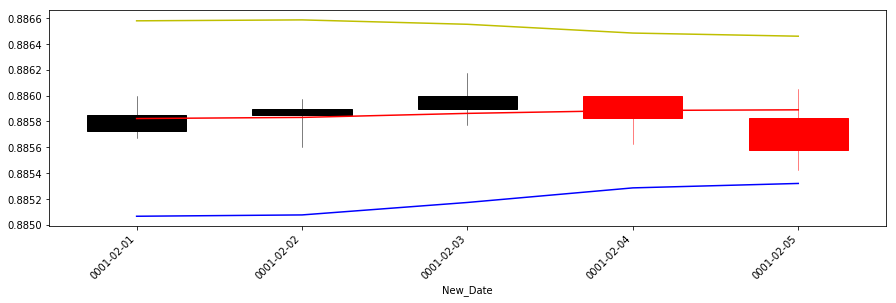

In [83]:
from matplotlib.dates import MONDAY, DateFormatter, DayLocator, WeekdayLocator

mondays = WeekdayLocator(MONDAY)        # major ticks on the mondays
alldays = DayLocator()              # minor ticks on the days
weekFormatter = DateFormatter('%b %d')  # e.g., Jan 12
dayFormatter = DateFormatter('%d')      # e.g., 12
hourFormatter = DateFormatter('%h')

fig1 = plt.figure(figsize=(15,15))
ax10 = plt.subplot(3,1,1)
fig1.subplots_adjust(bottom=0.2)
# ax10.xaxis.set_major_locator(mondays)
# ax10.xaxis.set_minor_locator(alldays)
# ax10.xaxis.set_major_formatter(dayFormatter)
ax10.xaxis.set_minor_formatter(hourFormatter)

### Charting by actual dates on X asis:
candlestick_ohlc(ax10, zip(mdates.date2num(min_1_analyzed_df_candle_chart.index),
                         min_1_analyzed_df_candle_chart['Open'], min_1_analyzed_df_candle_chart['High'],
                         min_1_analyzed_df_candle_chart['Low'], min_1_analyzed_df_candle_chart['Close']), width=0.6)
### Charting by intigers (converted to dates on the chart) on X asis:
# candlestick_ohlc(ax10, zip(min_1_analyzed_df_candle_chart.index,
#                           min_1_analyzed_df_candle_chart['Open'], min_1_analyzed_df_candle_chart['High'],
#                           min_1_analyzed_df_candle_chart['Low'], min_1_analyzed_df_candle_chart['Close']), width=0.6)
                           
min_1_analyzed_df_candle_chart["Middle_Band"].plot(ax=ax10, color="r")
min_1_analyzed_df_candle_chart["Upper_Band"].plot(ax=ax10, color="y")
min_1_analyzed_df_candle_chart["Lower_Band"].plot(ax=ax10, color="b")
min_1_analyzed_df_candle_chart["Seventy_SMA"].plot(ax=ax10, color="g")

ax10.xaxis_date()
ax10.autoscale_view()
plt.setp(plt.gca().get_xticklabels(), rotation=45, horizontalalignment='right')
plt.show()

c:\python 3.7\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "
c:\python 3.7\lib\site-packages\matplotlib\figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


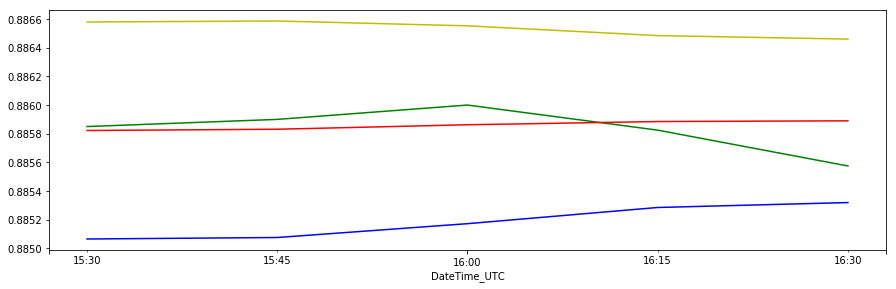

In [84]:
#%matplotlib inline

fig = plt.figure(figsize=(15,15))
ax1 = plt.subplot(3,1,1)
# Close price
min_1_analyzed_df_line_chart["Close"].plot(ax=ax1, color="g")
#min_1_analyzed_df.iloc[rows_to_chart,3:4].plot(ax=ax1, color="g")
ax2 = plt.subplot(3,1,1)
# Middle band (20SMA)
min_1_analyzed_df_line_chart["Middle_Band"].plot(ax=ax1, color="r")
#min_1_analyzed_df.iloc[rows_to_chart,6:7].plot(ax=ax1, color="r")
ax3 = plt.subplot(3,1,1)
# Upper band
min_1_analyzed_df_line_chart["Upper_Band"].plot(ax=ax1, color="y")
#min_1_analyzed_df.iloc[rows_to_chart,7:8].plot(ax=ax1, color="y")
# Lower band
min_1_analyzed_df_line_chart["Lower_Band"].plot(ax=ax1, color="b")
#min_1_analyzed_df.iloc[rows_to_chart,8:9].plot(ax=ax1, color="b")
plt.show()

## Calculating Factor's Profit and Loss

In [17]:
# class long_or_short_cls:
#     # Long = 0
#     # Short = 1
#     long_or_short = 0

class Pos_Open:
    is_position_open = False
    @classmethod
    def position_opened(cls, opened):
        if opened == True:
            cls.is_position_open = True
        else:
            cls.is_position_open = False
        
class Prft_lss_calc:
    entry_value = 0
    exit_value = 0
    prft_lss = 0
    # stop_price_at_entry = 0
    
    def round_down(self, n):
        return (np.floor(n*100))/100
        
    @classmethod
    def add_to_pos(cls, trade_price, long_or_short): # (cls, high_price, low_price, upper_band, lower_band, long_or_short)
        #For long:
        if long_or_short == "long":
            cls.entry_value = trade_price*Trade_Size.size # (lower_band + 0.0001)
            # cls.stop_price_at_entry = low_price
        #For short:
        else:
            cls.entry_value = trade_price*Trade_Size.size # (upper_band + 0.0001)
            # cls.stop_price_at_entry = high_price

    def prft_lss_cal_stopped_out(self, price, long_or_short):
        self.exit_value = price*Trade_Size.size
        # for long
        if long_or_short == "long":
            self.prft_lss = self.round_down(self.exit_value - Prft_lss_calc.entry_value)
        # for short
        else:
            self.prft_lss = self.round_down(Prft_lss_calc.entry_value - self.exit_value)
        return self.prft_lss
    
    def prft_lss_cal_took_prft(self, price, long_or_short):
        self.exit_value = price*Trade_Size.size
        # for long
        if long_or_short == "long":
            self.prft_lss = self.round_down(self.exit_value - Prft_lss_calc.entry_value)
        # for short
        else:
            self.prft_lss = self.round_down(Prft_lss_calc.entry_value - self.exit_value)
        return self.prft_lss
        
def trd_price_and_prft(row):
    
    p_l_calc = Prft_lss_calc()
    
    if (row.Action == "Entered") & (Pos_Open.is_position_open == False):
        p_l_calc.add_to_pos(round(float(row.Trade_Price),6), row.Long_Short) # (row.High, row.Low, row.Upper_Band, row.Lower_Band, row.Long_Short)
        Pos_Open.position_opened(True)
        return [p_l_calc.entry_value,0]
    
    elif ((row.Action == "Took Profit") | (row.Action == "Stopped Out")) & (Pos_Open.is_position_open == True):
#         Prft_lss_calc.close_pos(row.High)
        Pos_Open.position_opened(False)
        # if Took Profit
        if row.Action == "Took Profit":
            # for long:
            if row.Long_Short == "long":
                pric = round(float(row.Trade_Price),6) # row.Middle_Band + 0.0009
            # for short:
            else:
                pric = round(float(row.Trade_Price),6) # row.Middle_Band - 0.0009
            #list_to_return = 
            return [pric, p_l_calc.prft_lss_cal_took_prft(pric, row.Long_Short)]
        # if Stopped Out
        else:
            # for long:
            if row.Long_Short == "long":
                stopped_pric = round(float(row.Trade_Price),6) # p_l_calc.stop_price_at_entry - 0.0006
            # for short:
            else:
                stopped_pric = round(float(row.Trade_Price),6) # p_l_calc.stop_price_at_entry + 0.0006
            #list_to_return_1 = 
            return [stopped_pric, p_l_calc.prft_lss_cal_stopped_out(stopped_pric, row.Long_Short)]
    
    else:
        return[np.NaN,0]

min_1_analyzed_df["Trade_Prc_and_Prft"] = min_1_analyzed_df.apply(trd_price_and_prft, axis=1)

# def extract_prft_lss(Trade_Prc_and_Prft):
#     if len(Split_Action) > 1:
#         return Split_Action[-1]
#     else:
#         return np.nan

min_1_analyzed_df["Trade_Prft_Lss"] = min_1_analyzed_df["Trade_Prc_and_Prft"].apply(lambda x: x[1])
min_1_analyzed_df.head(80)

C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:91: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:99: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price,New_Date,Trade_Prc_and_Prft,Trade_Prft_Lss
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-19 08:00:00,0.885800,0.885850,0.885525,0.885775,2018-02-19 08:00:00,0.885021,0.886110,0.883933,0.884008,0.885932,...,0.885875,0.885300,"{2018-02-19 07:45:00: 0.8858, 2018-02-19 07:30...",0,Waiting,NaN,NaN,0001-01-02,"[nan, 0]",0.0
2018-02-19 08:15:00,0.885775,0.885775,0.885250,0.885300,2018-02-19 08:15:00,0.885051,0.886130,0.883972,0.883933,0.886110,...,0.885850,0.885525,"{2018-02-19 08:00:00: 0.885775, 2018-02-19 07:...",1,Waiting,NaN,NaN,0001-01-03,"[nan, 0]",0.0
2018-02-19 08:30:00,0.885300,0.885550,0.885225,0.885525,2018-02-19 08:30:00,0.885093,0.886186,0.883999,0.883972,0.886130,...,0.885775,0.885250,"{2018-02-19 08:15:00: 0.8853, 2018-02-19 08:00...",2,Waiting,NaN,NaN,0001-01-04,"[nan, 0]",0.0
2018-02-19 08:45:00,0.885525,0.885950,0.885425,0.885700,2018-02-19 08:45:00,0.885141,0.886275,0.884008,0.883999,0.886186,...,0.885550,0.885225,"{2018-02-19 08:30:00: 0.885525, 2018-02-19 08:...",3,Waiting,NaN,NaN,0001-01-05,"[nan, 0]",0.0
2018-02-19 09:00:00,0.885700,0.885800,0.885475,0.885725,2018-02-19 09:00:00,0.885195,0.886337,0.884053,0.884008,0.886275,...,0.885950,0.885425,"{2018-02-19 08:45:00: 0.8857, 2018-02-19 08:30...",4,Waiting,NaN,NaN,0001-01-06,"[nan, 0]",0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2018-02-20 14:45:00,0.882450,0.882875,0.882200,0.882800,2018-02-20 14:45:00,0.882256,0.884131,0.880382,0.880292,0.884090,...,0.882450,0.882025,"{2018-02-20 14:30:00: 0.88245, 2018-02-20 14:1...",75,Waiting,NaN,NaN,0001-03-18,"[nan, 0]",0.0
2018-02-20 15:00:00,0.882800,0.883225,0.882525,0.883000,2018-02-20 15:00:00,0.882338,0.884167,0.880508,0.880382,0.884131,...,0.882875,0.882200,"{2018-02-20 14:45:00: 0.8828, 2018-02-20 14:30...",76,Waiting,NaN,NaN,0001-03-19,"[nan, 0]",0.0
2018-02-20 15:15:00,0.883000,0.883225,0.882325,0.882600,2018-02-20 15:15:00,0.882375,0.884179,0.880571,0.880508,0.884167,...,0.883225,0.882525,"{2018-02-20 15:00:00: 0.883, 2018-02-20 14:45:...",77,Waiting,NaN,NaN,0001-03-20,"[nan, 0]",0.0


In [18]:
min_1_analyzed_df.loc[(min_1_analyzed_df["Period_Number"] > 24) & (min_1_analyzed_df["Period_Number"] < 40),:]

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price,New_Date,Trade_Prc_and_Prft,Trade_Prft_Lss
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-19 14:15:00,0.885800,0.885850,0.885625,0.885775,2018-02-19 14:15:00,0.885745,0.886542,0.884948,0.884947,0.886558,...,0.886125,0.885650,"{2018-02-19 14:00:00: 0.8858, 2018-02-19 13:45...",25,Waiting,NaN,NaN,0001-01-27,"[nan, 0]",0.0
2018-02-19 14:30:00,0.885775,0.886450,0.885675,0.886325,2018-02-19 14:30:00,0.885794,0.886629,0.884959,0.884948,0.886542,...,0.885850,0.885625,"{2018-02-19 14:15:00: 0.885775, 2018-02-19 14:...",26,Waiting,NaN,NaN,0001-01-28,"[nan, 0]",0.0
2018-02-19 14:45:00,0.886325,0.886375,0.885625,0.885675,2018-02-19 14:45:00,0.885804,0.886613,0.884994,0.884959,0.886629,...,0.886450,0.885675,"{2018-02-19 14:30:00: 0.886325, 2018-02-19 14:...",27,Waiting,NaN,NaN,0001-01-29,"[nan, 0]",0.0
2018-02-19 15:00:00,0.885675,0.885925,0.885575,0.885650,2018-02-19 15:00:00,0.885794,0.886609,0.884979,0.884994,0.886613,...,0.886375,0.885625,"{2018-02-19 14:45:00: 0.885675, 2018-02-19 14:...",28,Waiting,NaN,NaN,0001-01-30,"[nan, 0]",0.0
2018-02-19 15:15:00,0.885650,0.885900,0.885600,0.885725,2018-02-19 15:15:00,0.885809,0.886583,0.885034,0.884979,0.886609,...,0.885925,0.885575,"{2018-02-19 15:00:00: 0.88565, 2018-02-19 14:4...",29,Waiting,NaN,NaN,0001-01-31,"[nan, 0]",0.0
2018-02-19 15:30:00,0.885725,0.886000,0.885675,0.885850,2018-02-19 15:30:00,0.885823,0.886580,0.885065,0.885034,0.886583,...,0.885900,0.885600,"{2018-02-19 15:15:00: 0.885725, 2018-02-19 15:...",30,Waiting,NaN,NaN,0001-02-01,"[nan, 0]",0.0
2018-02-19 15:45:00,0.885850,0.885975,0.885600,0.885900,2018-02-19 15:45:00,0.885831,0.886587,0.885076,0.885065,0.886580,...,0.886000,0.885675,"{2018-02-19 15:30:00: 0.88585, 2018-02-19 15:1...",31,Waiting,NaN,NaN,0001-02-02,"[nan, 0]",0.0
2018-02-19 16:00:00,0.885900,0.886175,0.885775,0.886000,2018-02-19 16:00:00,0.885863,0.886553,0.885172,0.885076,0.886587,...,0.885975,0.885600,"{2018-02-19 15:45:00: 0.8859, 2018-02-19 15:30...",32,Waiting,NaN,NaN,0001-02-03,"[nan, 0]",0.0
2018-02-19 16:15:00,0.886000,0.886000,0.885625,0.885825,2018-02-19 16:15:00,0.885885,0.886485,0.885285,0.885172,0.886553,...,0.886175,0.885775,"{2018-02-19 16:00:00: 0.8859999999999999, 2018...",33,Waiting,NaN,NaN,0001-02-04,"[nan, 0]",0.0


In [87]:
#min_1_analyzed_df[min_1_analyzed_df["Period_Number"] > 240]

In [29]:
min_1_analyzed_df_dist_analysis = min_1_analyzed_df[min_1_analyzed_df["Action"] != "Waiting"]
min_1_analyzed_df_dist_analysis
# min_1_analyzed_df_dist_analysis[min_1_analyzed_df_dist_analysis["Trade_Prft_Lss"]>=0]

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Prev_High,Prev_Low,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price,New_Date,Trade_Prc_and_Prft,Trade_Prft_Lss
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-20 09:15:00,0.885050,0.885675,0.884800,0.885575,2018-02-20 09:15:00,0.886004,0.887006,0.885001,0.885057,0.887033,...,0.885675,0.884400,"{2018-02-20 09:00:00: 0.88505, 2018-02-20 08:4...",53,Entered,long,0.885107,0001-02-24,"[17702.14, 0]",0.00
2018-02-20 09:30:00,0.885575,0.885650,0.882475,0.883075,2018-02-20 09:30:00,0.885846,0.888039,0.883653,0.885001,0.887006,...,0.885675,0.884800,"{2018-02-20 09:15:00: 0.885575, 2018-02-20 09:...",54,Stopped Out,long,0.8834,0001-02-25,"[0.8834, -34.14]",-34.14
2018-02-20 10:00:00,0.881500,0.882225,0.881125,0.881375,2018-02-20 10:00:00,0.885361,0.889923,0.880799,0.881983,0.889235,...,0.883100,0.881375,"{2018-02-20 09:45:00: 0.8815, 2018-02-20 09:30...",56,Entered,long,0.881225,0001-02-27,"[17624.5, 0]",0.00
2018-02-21 08:15:00,0.881750,0.882575,0.881625,0.882475,2018-02-21 08:15:00,0.881554,0.882594,0.880513,0.880695,0.882320,...,0.881975,0.880925,"{2018-02-21 08:00:00: 0.88175, 2018-02-21 07:4...",97,Took Profit,long,0.882475,0001-04-09,"[0.882475, 25.0]",25.00
2018-02-21 09:45:00,0.883575,0.884075,0.882900,0.882925,2018-02-21 09:45:00,0.881869,0.883902,0.879836,0.879869,0.883708,...,0.884825,0.882025,"{2018-02-21 09:30:00: 0.883575, 2018-02-21 09:...",103,Entered,short,0.883325,0001-04-15,"[17666.5, 0]",0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-31 09:15:00,0.890175,0.890250,0.888050,0.888975,2020-03-31 09:15:00,0.892525,0.896436,0.888614,0.889714,0.895721,...,0.891800,0.889275,"{2020-03-31 09:00:00: 0.890175, 2020-03-31 08:...",24347,Stopped Out,long,0.888275,0067-08-31,"[0.888275, -23.0]",-23.00
2020-04-01 08:15:00,0.886425,0.886525,0.884925,0.885800,2020-04-01 08:15:00,0.889462,0.893710,0.885215,0.886277,0.893018,...,0.887600,0.886375,"{2020-04-01 08:00:00: 0.886425, 2020-04-01 07:...",24391,Entered,long,0.885317,0067-10-14,"[17706.34, 0]",0.00
2020-04-01 09:15:00,0.884375,0.885175,0.883900,0.884475,2020-04-01 09:15:00,0.888467,0.895105,0.881830,0.882661,0.894844,...,0.886800,0.884175,"{2020-04-01 09:00:00: 0.884375, 2020-04-01 08:...",24395,Stopped Out,long,0.883925,0067-10-18,"[0.883925, -27.85]",-27.85


### P&L time distribution

#### Prep

In [20]:
min_1_analyzed_df_dist_analysis["Trade_Entry_Time"] = min_1_analyzed_df_dist_analysis.index
min_1_analyzed_df_dist_analysis["Trade_Entry_Time_Shifted"] = min_1_analyzed_df_dist_analysis["Trade_Entry_Time"].shift(1)
min_1_analyzed_df_dist_analysis.drop("Trade_Entry_Time",axis=1, inplace=True)
min_1_analyzed_df_dist_analysis_exists_only = min_1_analyzed_df_dist_analysis.loc[((min_1_analyzed_df_dist_analysis \
["Action"] == "Took Profit") | (min_1_analyzed_df_dist_analysis["Action"] == "Stopped Out")),:]
min_1_analyzed_df_dist_analysis_exists_only["Hour_of_Entry"] = min_1_analyzed_df_dist_analysis_exists_only \
["Trade_Entry_Time_Shifted"].apply(lambda x: x.hour)

C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\radoC\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
c:\python 3.7\lib\site-packages\pandas\core\frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pa

In [21]:
min_1_analyzed_df_dist_analysis_exists_only

,Open,High,Low,Close,DateTime_UTC_column,Middle_Band,Upper_Band,Lower_Band,Prev_Lower_Band,Prev_Upper_Band,...,Dict_of_Closing_Prices,Period_Number,Action,Long_Short,Trade_Price,New_Date,Trade_Prc_and_Prft,Trade_Prft_Lss,Trade_Entry_Time_Shifted,Hour_of_Entry
DateTime_UTC,,,,,,,,,,,,,,,,,,,,,
2018-02-20 09:30:00,0.885575,0.885650,0.882475,0.883075,2018-02-20 09:30:00,0.885846,0.888039,0.883653,0.885001,0.887006,...,"{2018-02-20 09:15:00: 0.885575, 2018-02-20 09:...",54,Stopped Out,long,0.8834,0001-02-25,"[0.8834, -34.14]",-34.14,2018-02-20 09:15:00,9
2018-02-21 08:15:00,0.881750,0.882575,0.881625,0.882475,2018-02-21 08:15:00,0.881554,0.882594,0.880513,0.880695,0.882320,...,"{2018-02-21 08:00:00: 0.88175, 2018-02-21 07:4...",97,Took Profit,long,0.882475,0001-04-09,"[0.882475, 25.0]",25.00,2018-02-20 10:00:00,10
2018-02-21 11:15:00,0.884625,0.885575,0.884475,0.884625,2018-02-21 11:15:00,0.882598,0.886221,0.878974,0.879064,0.885829,...,"{2018-02-21 11:00:00: 0.884625, 2018-02-21 10:...",109,Stopped Out,short,0.885075,0001-04-21,"[0.885075, -35.0]",-35.00,2018-02-21 09:45:00,9
2018-02-22 08:00:00,0.883850,0.884125,0.883475,0.884075,2018-02-22 08:00:00,0.882978,0.884731,0.881224,0.881334,0.884488,...,"{2018-02-22 07:45:00: 0.88385, 2018-02-22 07:3...",144,Took Profit,long,0.883875,0001-05-26,"[0.883875, 41.0]",41.00,2018-02-21 15:15:00,15
2018-02-23 11:45:00,0.881450,0.881625,0.880075,0.880400,2018-02-23 11:45:00,0.881301,0.882893,0.879709,0.879842,0.882930,...,"{2018-02-23 11:30:00: 0.88145, 2018-02-23 11:1...",207,Took Profit,short,0.880375,0001-07-28,"[0.880375, 65.97]",65.97,2018-02-23 11:00:00,11
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-26 19:45:00,0.905450,0.906600,0.903400,0.904050,2020-03-26 19:45:00,0.908116,0.914319,0.901913,0.902506,0.914514,...,"{2020-03-26 19:30:00: 0.90545, 2020-03-26 19:1...",24245,Stopped Out,long,0.904825,0067-05-21,"[0.904825, -37.0]",-37.00,2020-03-26 16:00:00,16
2020-03-27 08:45:00,0.905600,0.907200,0.904725,0.905425,2020-03-27 08:45:00,0.903327,0.906665,0.899990,0.899897,0.906356,...,"{2020-03-27 08:30:00: 0.9056, 2020-03-27 08:15...",24249,Stopped Out,short,0.90715,0067-05-25,"[0.90715, -27.5]",-27.50,2020-03-27 08:30:00,8
2020-03-31 09:15:00,0.890175,0.890250,0.888050,0.888975,2020-03-31 09:15:00,0.892525,0.896436,0.888614,0.889714,0.895721,...,"{2020-03-31 09:00:00: 0.890175, 2020-03-31 08:...",24347,Stopped Out,long,0.888275,0067-08-31,"[0.888275, -23.0]",-23.00,2020-03-31 09:00:00,9


#### Time distribution of Profits

AxesSubplot(0.125,0.125;0.775x0.755)


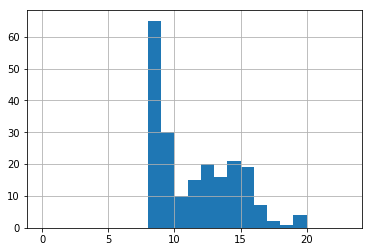

In [24]:
print(min_1_analyzed_df_dist_analysis_exists_only[min_1_analyzed_df_dist_analysis_exists_only["Trade_Prft_Lss"]>0] \
["Hour_of_Entry"].hist(bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,23]));

#### Time distribution of losses

AxesSubplot(0.125,0.125;0.775x0.755)


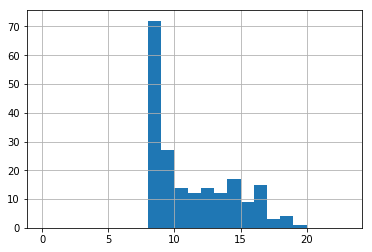

In [25]:
print(min_1_analyzed_df_dist_analysis_exists_only[min_1_analyzed_df_dist_analysis_exists_only["Trade_Prft_Lss"]<=0] \
["Hour_of_Entry"].hist(bins=[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23]));

## Result (P & L)

# of Trades: 410
                                                                      
        count       mean        std     min   25%     50%   75%    max
Loss    200.0 -29.640150  11.203314 -127.50 -32.0 -27.000 -24.0   -3.5
Profit  210.0  41.572286  22.689578    4.18  26.5  37.825  50.2  189.0
Gross P&L: 2802.15 (14.01075%)
Commission: 820
Slippage: 820.0
Net P&L: 1162.15 (5.8107500000000005%)


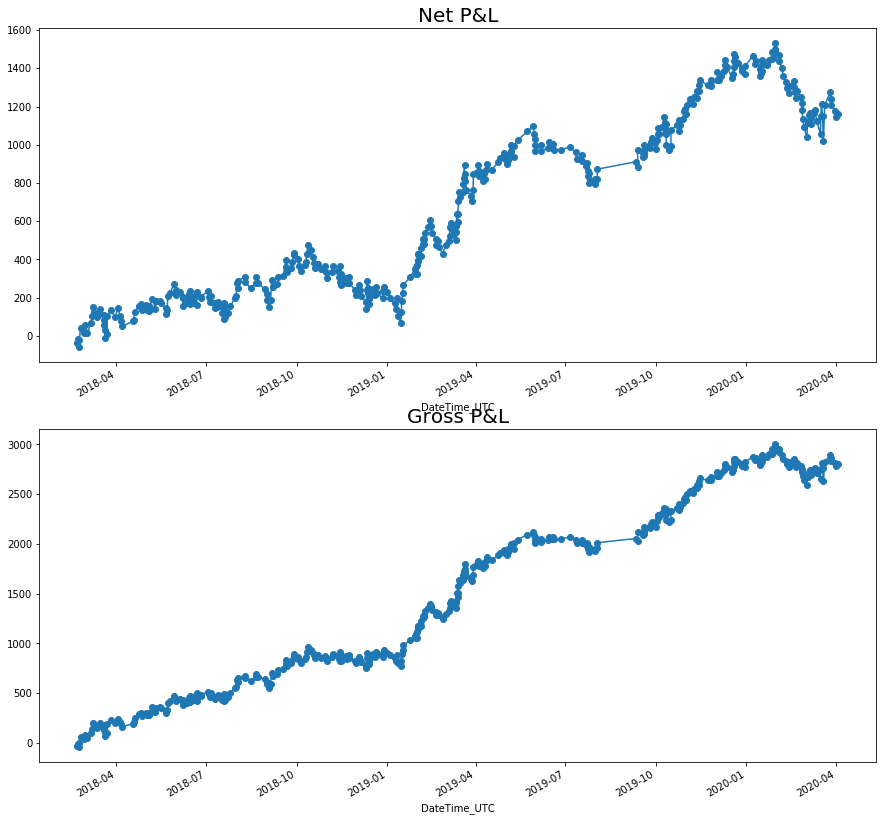

In [26]:
# Gross P&L:
gross_absolute_profit_loss = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].sum()
gross_percent_profit_loss = (gross_absolute_profit_loss/Trade_Size.size)*100

# Commission:
commission = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].count()*2

#Slippage:
slippage = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].count()*(Trade_Size.size/10000)

# Net P&L:
net_absolute_profit_loss = gross_absolute_profit_loss - commission - slippage
net_percent_profit_loss = (net_absolute_profit_loss/Trade_Size.size)*100

# Number of trades:
num_of_trades = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"].count()

# Print table
profit_vs_loss = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"] > 0
profit_vs_loss.replace({True:"Profit",False:"Loss"}, inplace=True)
s = min_1_analyzed_df.loc[min_1_analyzed_df["Trade_Prft_Lss"] != 0.0,"Trade_Prft_Lss"]
pft_df = pd.concat([profit_vs_loss,s], axis=1)
pft_df.columns = ["Trade_Prft_Lss_Name","Trade_Prft_Lss_Value"]
P_N_L_Stats = pft_df.groupby(["Trade_Prft_Lss_Name"],sort=False).describe()
P_N_L_Stats.rename(columns={"Trade_Prft_Lss_Value":""},level=0,inplace=True)
P_N_L_Stats.index.name = None
# P_N_L_Stats = pd.DataFrame({"Count":profit_vs_loss.value_counts(ascending=True).values,"Average":[s[s>0].mean(),
# s[s<0].mean()]},index=profit_vs_loss.value_counts().index)

print("# of Trades: {}".format(num_of_trades))
print(P_N_L_Stats)
print("Gross P&L: {} ({}%)".format(gross_absolute_profit_loss,gross_percent_profit_loss))
print("Commission: {}".format(commission))
print("Slippage: {}".format(slippage))
print("Net P&L: {} ({}%)".format(net_absolute_profit_loss,net_percent_profit_loss))

# Charting P&L:
pnl_chart_df = min_1_analyzed_df["Trade_Prft_Lss"].replace(0,np.NaN)
pnl_chart_df_cumsum = pnl_chart_df[pnl_chart_df < 1000000000].cumsum()
pnl_chart_df_less_comm_and_slip = pnl_chart_df - 2 - Trade_Size.size/10000
pnl_chart_df_less_comm_and_slip_cumsum = pnl_chart_df_less_comm_and_slip[pnl_chart_df_less_comm_and_slip < 1000000000].cumsum()

fig1 = plt.figure(figsize=(15,15))
ax4 = plt.subplot(2,1,1)
ax4.set_title("Net P&L", fontsize=20)
pnl_chart_df_less_comm_and_slip_cumsum.plot(ax=ax4, linestyle="-", marker="o")
ax5 = plt.subplot(2,1,2)
ax5.set_title("Gross P&L", fontsize=20)
pnl_chart_df_cumsum.plot(ax=ax5, linestyle="-", marker="o")
plt.show()
# ax2 = plt.subplot(3,1,1)
# min_1_analyzed_df["SMA10"].head(100).plot(ax=ax1, color="r")
# ax3 = plt.subplot(3,1,1)
# min_1_analyzed_df["SMA20"].head(100).plot(ax=ax1, color="y")

In [38]:
from sklearn.model_selection import ParameterGrid

grid = ParameterGrid({"max_samples": [0.5, 1.0],
                          "max_features": [0.5, 1.0],
                          "bootstrap": [True, False],
                          "bootstrap_features": [True, False]})
for params in grid:
    print(params)

{'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.5}
{'bootstrap': True, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0}
{'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 0.5}
{'bootstrap': True, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 1.0}
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 0.5}
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 0.5, 'max_samples': 1.0}
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 0.5}
{'bootstrap': True, 'bootstrap_features': False, 'max_features': 1.0, 'max_samples': 1.0}
{'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 0.5}
{'bootstrap': False, 'bootstrap_features': True, 'max_features': 0.5, 'max_samples': 1.0}
{'bootstrap': False, 'bootstrap_features': True, 'max_features': 1.0, 'max_samples': 0.5}
{'bootstrap': 